<a href="https://colab.research.google.com/github/stefanroata/LM-meets-DL/blob/main/IKSA_SGD_Training_and_Loss_Landscape_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import copy
import torchvision
import numpy as np
import os
from tqdm import tqdm
from torchvision import transforms as T
from torchvision import models
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torch.optim as optim
from google.colab import drive

In [ ]:
# ONLY AVAILABLE IF WORKING INSIDE GOOGLE COLAB
# IF NOT WORKING INSIDE GOOGLE COLAB, PLEASE IGNORE THIS CELL
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/CAPSTONE/')

Mounted at /content/gdrive


In [ ]:
from IKSA_optimizers.SGD_IKSA import SGD_IKSA

In [ ]:
!nvidia-smi -L 

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8c4a3c3f-4d87-6995-5b7e-8a6c1b0760ca)


In [ ]:
# dir(models)
model_ident = 'mobilenet_v2'
optimizer_name = 'SGD_IKSA'
dataset_name = 'imagenetv2'


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', model_ident, weights = None, verbose=False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip


In [ ]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
path_to_dataset = "imagenetv2-threshold0.7-format-val"

dataset = torchvision.datasets.ImageFolder(root=path_to_dataset,
                                            transform=T.Compose([T.Resize(256),
                                                                 T.CenterCrop(224),
                                                                 T.ToTensor(),
                                                                 T.Normalize(mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225])]))

In [ ]:
dataset_size = len(dataset)
print("Dateset Size: ", dataset_size)
classes = dataset.classes
print("Classes: ", classes[0:10])

Dateset Size:  10000
Classes:  ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106']


In [ ]:
img, label = dataset[1]
img_shape = img.shape
img_shape

torch.Size([3, 224, 224])

Label (numeric): 0
Label (textual): 0
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


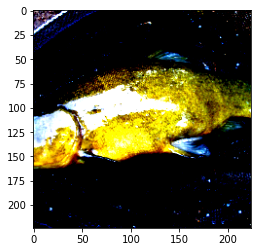

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])
print(type(img))
print(img.size())

In [ ]:
torch.manual_seed(1234)
BATCH_SIZE= 50
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [ ]:
N_EPOCHS = 100
LR = 0.05
# LM_c = 4
# different values of c: 5, 4, 3, 2, 1, current loss at that stage (loss.item())
identity_function = lambda x: x
square_function = lambda x: x**2
arctan_x_sq_function = lambda x: torch.atan(x**2)
fname = "arctan(x^2)"
# --------------------------------------------
criterion = torch.nn.CrossEntropyLoss()
# choose different optimizers: RMSProp, Adam
optimizer = SGD_IKSA(model.parameters(), lr=LR, function=arctan_x_sq_function, eps_IAKSA = 1)

In [ ]:
MAX_ACC = 0

for epoch in range(N_EPOCHS):
  running_loss = 0
  correct = 0
  total = 0
  for inputs, labels in tqdm(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
    loss = criterion(outputs, labels)
    loss.backward()
    LM_c = loss.item()
    optimizer.step(LM_c, loss)
    running_loss += loss.item()
  
  train_loss = running_loss / len(train_loader)
  accuracy = 100 * correct / total
  print(f'Train Loss : {train_loss} ;   Accuracy : {accuracy}%')

  if accuracy > MAX_ACC:
    torch.save(model, f'{dataset_name}_{optimizer_name}_C=running_loss_f={fname}_{model_ident}_best_train_acc.pt')
    MAX_ACC = accuracy

100%|██████████| 200/200 [12:27<00:00,  3.74s/it]


Train Loss : 6.978603506088257 ;   Accuracy : 0.03%


100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


Train Loss : 6.921710774898529 ;   Accuracy : 0.11%


100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


Train Loss : 6.797751657962799 ;   Accuracy : 0.22%


100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


Train Loss : 6.631357505321502 ;   Accuracy : 0.44%


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Train Loss : 6.483363971710205 ;   Accuracy : 0.68%


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Train Loss : 6.349595057964325 ;   Accuracy : 0.81%


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Train Loss : 6.206154315471649 ;   Accuracy : 1.06%


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Train Loss : 6.067469666004181 ;   Accuracy : 1.61%


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


Train Loss : 5.9365322256088255 ;   Accuracy : 2.04%


100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


Train Loss : 5.8001069784164425 ;   Accuracy : 2.46%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 5.666116704940796 ;   Accuracy : 3.08%


100%|██████████| 200/200 [00:46<00:00,  4.34it/s]


Train Loss : 5.532141687870026 ;   Accuracy : 4.1%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 5.416310448646545 ;   Accuracy : 4.72%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 5.2842649507522585 ;   Accuracy : 5.27%


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Train Loss : 5.167864091396332 ;   Accuracy : 5.99%


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Train Loss : 5.04525164604187 ;   Accuracy : 7.02%


100%|██████████| 200/200 [00:45<00:00,  4.42it/s]


Train Loss : 4.9091576790809635 ;   Accuracy : 8.21%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 4.792604651451111 ;   Accuracy : 9.16%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 4.670086195468903 ;   Accuracy : 10.44%


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Train Loss : 4.543700556755066 ;   Accuracy : 11.37%


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Train Loss : 4.4081695997715 ;   Accuracy : 13.06%


100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


Train Loss : 4.282959982156753 ;   Accuracy : 14.87%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 4.132212849855423 ;   Accuracy : 16.27%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 3.9910212779045104 ;   Accuracy : 18.71%


100%|██████████| 200/200 [00:45<00:00,  4.42it/s]


Train Loss : 3.86065212726593 ;   Accuracy : 20.74%


100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


Train Loss : 3.725482404232025 ;   Accuracy : 22.57%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 3.5555936634540557 ;   Accuracy : 24.9%


100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


Train Loss : 3.406595904827118 ;   Accuracy : 27.49%


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Train Loss : 3.2754858779907225 ;   Accuracy : 29.81%


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Train Loss : 3.0951298987865448 ;   Accuracy : 33.45%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 2.9348147654533387 ;   Accuracy : 36.07%


100%|██████████| 200/200 [00:46<00:00,  4.35it/s]


Train Loss : 2.7862170827388764 ;   Accuracy : 38.81%


100%|██████████| 200/200 [00:46<00:00,  4.33it/s]


Train Loss : 2.6301538640260698 ;   Accuracy : 42.84%


100%|██████████| 200/200 [00:46<00:00,  4.34it/s]


Train Loss : 2.4598628342151643 ;   Accuracy : 45.34%


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Train Loss : 2.2694074565172198 ;   Accuracy : 50.43%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 2.090635195374489 ;   Accuracy : 54.28%


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


Train Loss : 1.9666289043426515 ;   Accuracy : 56.58%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 1.7871092009544371 ;   Accuracy : 61.55%


100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


Train Loss : 1.6201005619764328 ;   Accuracy : 65.31%


100%|██████████| 200/200 [00:45<00:00,  4.35it/s]


Train Loss : 1.4754870730638503 ;   Accuracy : 68.48%


100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


Train Loss : 1.2891243103146552 ;   Accuracy : 73.29%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 1.1333194327354432 ;   Accuracy : 77.57%


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Train Loss : 0.9943822875618935 ;   Accuracy : 81.11%


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Train Loss : 0.8411568166315555 ;   Accuracy : 85.35%


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Train Loss : 0.7005587339401245 ;   Accuracy : 88.73%


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


Train Loss : 0.5912590140104294 ;   Accuracy : 91.49%


100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


Train Loss : 0.4757001327723265 ;   Accuracy : 93.61%


100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


Train Loss : 0.39282447963953016 ;   Accuracy : 95.62%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 0.3250061821192503 ;   Accuracy : 96.5%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 0.25971648149192333 ;   Accuracy : 97.7%


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Train Loss : 0.2364516004920006 ;   Accuracy : 98.02%


100%|██████████| 200/200 [00:45<00:00,  4.42it/s]


Train Loss : 0.18573813002556563 ;   Accuracy : 98.75%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 0.1468131808191538 ;   Accuracy : 99.27%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 0.11567685171961785 ;   Accuracy : 99.56%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 0.09949219968169927 ;   Accuracy : 99.73%


100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


Train Loss : 0.0904192054644227 ;   Accuracy : 99.59%


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


Train Loss : 0.08546070565469563 ;   Accuracy : 99.74%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 0.07937006864696741 ;   Accuracy : 99.72%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 0.06663651718758047 ;   Accuracy : 99.84%


100%|██████████| 200/200 [00:46<00:00,  4.35it/s]


Train Loss : 0.05335711471736431 ;   Accuracy : 99.96%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 0.0515242156945169 ;   Accuracy : 99.91%


100%|██████████| 200/200 [00:45<00:00,  4.35it/s]


Train Loss : 0.051013902155682446 ;   Accuracy : 99.9%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 0.04627931229770184 ;   Accuracy : 99.93%


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Train Loss : 0.040746631771326064 ;   Accuracy : 99.97%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 0.03748746000695974 ;   Accuracy : 99.92%


100%|██████████| 200/200 [00:46<00:00,  4.29it/s]


Train Loss : 0.03451794036664069 ;   Accuracy : 100.0%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 0.03701739058829844 ;   Accuracy : 99.93%


100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


Train Loss : 0.032160832532681524 ;   Accuracy : 99.98%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 0.03898369074333459 ;   Accuracy : 99.79%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 0.03174175525084138 ;   Accuracy : 99.96%


100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


Train Loss : 0.030030150124803187 ;   Accuracy : 99.96%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 0.029019331918098034 ;   Accuracy : 99.92%


100%|██████████| 200/200 [00:46<00:00,  4.34it/s]


Train Loss : 0.028246457576751708 ;   Accuracy : 99.95%


100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


Train Loss : 0.027387703633867205 ;   Accuracy : 99.96%


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Train Loss : 0.023370305644348263 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 0.025377163947559893 ;   Accuracy : 99.97%


100%|██████████| 200/200 [00:47<00:00,  4.24it/s]


Train Loss : 0.022516840226016938 ;   Accuracy : 99.98%


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Train Loss : 0.023259796584025026 ;   Accuracy : 99.97%


100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


Train Loss : 0.020914054666645823 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Train Loss : 0.01940759913995862 ;   Accuracy : 100.0%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 0.020674433920066803 ;   Accuracy : 99.97%


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Train Loss : 0.019140242671128363 ;   Accuracy : 99.95%


100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


Train Loss : 0.01843086738139391 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


Train Loss : 0.01973305326886475 ;   Accuracy : 99.97%


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Train Loss : 0.017599464256782084 ;   Accuracy : 99.98%


100%|██████████| 200/200 [00:46<00:00,  4.33it/s]


Train Loss : 0.017496057096868755 ;   Accuracy : 100.0%


100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


Train Loss : 0.017490311574656515 ;   Accuracy : 99.97%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 0.015737499988172202 ;   Accuracy : 100.0%


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Train Loss : 0.014559479849413037 ;   Accuracy : 99.98%


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


Train Loss : 0.01885909166187048 ;   Accuracy : 99.94%


100%|██████████| 200/200 [00:45<00:00,  4.35it/s]


Train Loss : 0.0159799653547816 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


Train Loss : 0.014124988454859704 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Train Loss : 0.0158992180461064 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:46<00:00,  4.31it/s]


Train Loss : 0.014237205926328898 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:46<00:00,  4.29it/s]


Train Loss : 0.013130675500724465 ;   Accuracy : 99.98%


100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


Train Loss : 0.013241032375954092 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:46<00:00,  4.34it/s]


Train Loss : 0.014156003098469228 ;   Accuracy : 99.98%


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


Train Loss : 0.013181797708384693 ;   Accuracy : 100.0%


100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


Train Loss : 0.012662501728627831 ;   Accuracy : 99.99%


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]

Train Loss : 0.012669467732775956 ;   Accuracy : 99.99%


The values of C to use should be 7, 6, 5, 4, 3, 2, 1, running_loss

In [ ]:
MDL = torch.load(f'{dataset_name}_{optimizer_name}_C=running_loss_f={fname}_{model_ident}_best_train_acc.pt', map_location=torch.device('cpu')).eval()
MDL = MDL.to('cuda')

In [ ]:
# EVALUATE THE ACCURACY OF THE SAVED MODEL
correct = 0
total = 0
for inputs, labels in tqdm(train_loader):
  inputs, labels = inputs.to('cuda'), labels.to('cuda')
  outputs = MDL(inputs)
  correct += (outputs.argmax(axis=1)==labels).sum().item()
  total += labels.size(0)
  # del MDL, inputs, labels
  torch.cuda.empty_cache()
  
accuracy = 100. * correct / total
print('Train Accuracy: %.2f \n'%accuracy)

100%|██████████| 200/200 [00:42<00:00,  4.73it/s]

Train Accuracy: 100.00 



In [ ]:
def init_directions(model):
    noises = []

    n_params = 0
    for name, param in model.named_parameters():
        delta = torch.normal(.0, 1., size=param.size())
        nu = torch.normal(.0, 1., size=param.size())

        param_norm = torch.norm(param)
        delta_norm = torch.norm(delta)
        nu_norm = torch.norm(nu)

        delta /= delta_norm
        delta *= param_norm

        nu /= nu_norm
        nu *= param_norm

        noises.append((delta, nu))

        n_params += np.prod(param.size())

    print(f'A total of {n_params:,} parameters.')

    return noises


def init_network(model, all_noises, alpha, beta):
    with torch.no_grad():
        for param, noises in zip(model.parameters(), all_noises):
            delta, nu = noises
            new_value = param + alpha * delta + beta * nu
            param.copy_(new_value)
    return model


In [ ]:
def load_model(model_identifier):
    return torch.hub.load('pytorch/vision:v0.6.0', model_identifier, pretrained=True, verbose=False).eval()

model_id = 'mobilenet_v2'

def load_model_new (model_identifier):
  optimizer_name = 'SGD_IKSA'
  dataset_name = 'imagenetv2'
  return torch.load(f'{dataset_name}_{optimizer_name}_C=running_loss_f={fname}_{model_ident}_best_train_acc.pt', map_location=torch.device('cpu')).eval()

In [ ]:
def run_landscape_gen(batch_size, resolution, path_to_dataset):
    BATCH_SIZE = batch_size
    RESOLUTION = resolution

    dataset = torchvision.datasets.ImageFolder(root=path_to_dataset,
                                            transform=T.Compose([T.Resize(256),
                                                                 T.CenterCrop(224),
                                                                 T.ToTensor(),
                                                                 T.Normalize(mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225])]))
    
    torch.manual_seed(1234)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    print(f'Testing {model_id}')

    noises = init_directions(load_model_new(model_id))

    crit = torch.nn.CrossEntropyLoss()

    A, B = np.meshgrid(np.linspace(-1, 1, RESOLUTION),
                        np.linspace(-1, 1, RESOLUTION), indexing='ij')
    # SAVE X AND Y VALUES
    np.save(f'{model_id}_xx_{dataset_name}_{optimizer_name}_C=running_loss_f={fname}.npy', A)
    np.save(f'{model_id}_yy_{dataset_name}_{optimizer_name}_C=running_loss_f={fname}.npy', B)
    
    # CHECK IF FILE ALREADY EXISTS AND START FROM THERE
    if os.path.exists(f'{model_id}_zz_{dataset_name}_{optimizer_name}_C=running_loss_f={fname}.npy'):
      partial_array = np.load(f'{model_id}_zz_{dataset_name}_{optimizer_name}_C=running_loss_f={fname}.npy')
      resume_index = int(np.where(~partial_array.any(axis=1))[0][0])
      loss_surface = partial_array
    else:
      resume_index = 0
      loss_surface = np.zeros_like(A)

    
    print(f"Resuming Computation from Index {resume_index}\n")
    for i in range(resume_index, RESOLUTION):
        for j in range(RESOLUTION):
            total_loss = 0.
            n_batch = 0
            alpha = A[i, j]
            beta = B[i, j]
            net = init_network(load_model_new(model_id), noises, alpha, beta).to('cuda')
            for batch, labels in dataloader:
                batch = batch.to('cuda')
                labels = labels.to('cuda')
                with torch.no_grad():
                    preds = net(batch)
                    loss = crit(preds, labels)
                    total_loss += loss.item()
                    n_batch += 1
            loss_surface[i, j] = total_loss / n_batch
            del net, batch, labels
            print(f'alpha : {alpha:.2f}, beta : {beta:.2f}, loss : {loss_surface[i, j]:.2f}')
            torch.cuda.empty_cache()
        # save computed losses so far
        np.save(f'{model_id}_zz_{dataset_name}_{optimizer_name}_C=running_loss_f={fname}.npy', loss_surface)

In [ ]:
# os.environ['WANDB_CONSOLE'] = 'off'
# THE NUMBER OF WORKERS MIGHT BE TOO BIG FOR THIS GPU

In [ ]:
run_landscape_gen(50, 20, "imagenetv2-threshold0.7-format-val")

Testing mobilenet_v2
A total of 3,504,872 parameters.
Resuming Computation from Index 0

alpha : -1.00, beta : -1.00, loss : 26.23
alpha : -1.00, beta : -0.89, loss : 26.45
alpha : -1.00, beta : -0.79, loss : 26.37
alpha : -1.00, beta : -0.68, loss : 25.41
alpha : -1.00, beta : -0.58, loss : 25.54
alpha : -1.00, beta : -0.47, loss : 24.12
alpha : -1.00, beta : -0.37, loss : 21.64
alpha : -1.00, beta : -0.26, loss : 21.20
alpha : -1.00, beta : -0.16, loss : 18.56
alpha : -1.00, beta : -0.05, loss : 17.88
alpha : -1.00, beta : 0.05, loss : 17.60
alpha : -1.00, beta : 0.16, loss : 18.08
alpha : -1.00, beta : 0.26, loss : 18.48
alpha : -1.00, beta : 0.37, loss : 18.44
alpha : -1.00, beta : 0.47, loss : 19.26
alpha : -1.00, beta : 0.58, loss : 20.13
alpha : -1.00, beta : 0.68, loss : 21.06
alpha : -1.00, beta : 0.79, loss : 21.82
alpha : -1.00, beta : 0.89, loss : 22.11
alpha : -1.00, beta : 1.00, loss : 22.62
alpha : -0.89, beta : -1.00, loss : 24.67
alpha : -0.89, beta : -0.89, loss : 24.

In [ ]:
# parser = argparse.ArgumentParser(description='Arguments to generate loss landscape.')
# parser.add_argument('--path_to_imagenetv2', default='/mnt/storage/datasets/imagenetv2-top-images-format-val/', type=str)
# parser.add_argument('--batch_size', default=8, type=int)
# parser.add_argument('--resolution', default=25, type=int)

# plt.figure(figsize=(18, 12))
# plt.contour(A, B, loss_surface)
# plt.savefig(f'{model_id}_contour_optim_{optimizer_name}_bs_{BATCH_SIZE}_res_{RESOLUTION}_{dataset_name}.png', dpi=100)
# plt.close()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import networkx
plt.rcParams["figure.figsize"] = (20,20)

def generate_plots(model, dataset, optimizer_name, c_value):

    xx = np.load(model + "_xx_"+ dataset + "_" + optimizer_name + "_C=" + str(c_value) + "_f=" + fname + ".npy")
    yy = np.load(model + "_yy_"+ dataset + "_" + optimizer_name + "_C=" + str(c_value) + "_f=" + fname + ".npy")
    zz = np.load(model + "_zz_"+ dataset + "_" + optimizer_name + "_C=" + str(c_value) + "_f=" + fname + ".npy")

    plt.figure(figsize=(20, 20))
    plt.contour(xx, yy, zz)
    plt.savefig(f'{model}_contour_{dataset}_{optimizer_name}_C={c_value}.png', dpi=150)
    plt.close()

    ## 3D plot
    fig, ax = plt.subplots(subplot_kw={'projection' : '3d'})
    #ax.set_axis_off()
    surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(0, 30)
    # print(ax.azim, ax.elev)
    #ax.elev = 20
    #ax.azim = -20
    #c_plane = np.array(np.full((20, 20), 10))
    #ax.plot_surface(xx, yy, c_plane, cmap = "viridis", zorder = 1)

    plt.savefig(f'{model}_surface_{dataset}_{optimizer_name}_C={c_value}_f={fname}.png', dpi=300,format='png', bbox_inches = "tight")
    plt.show()


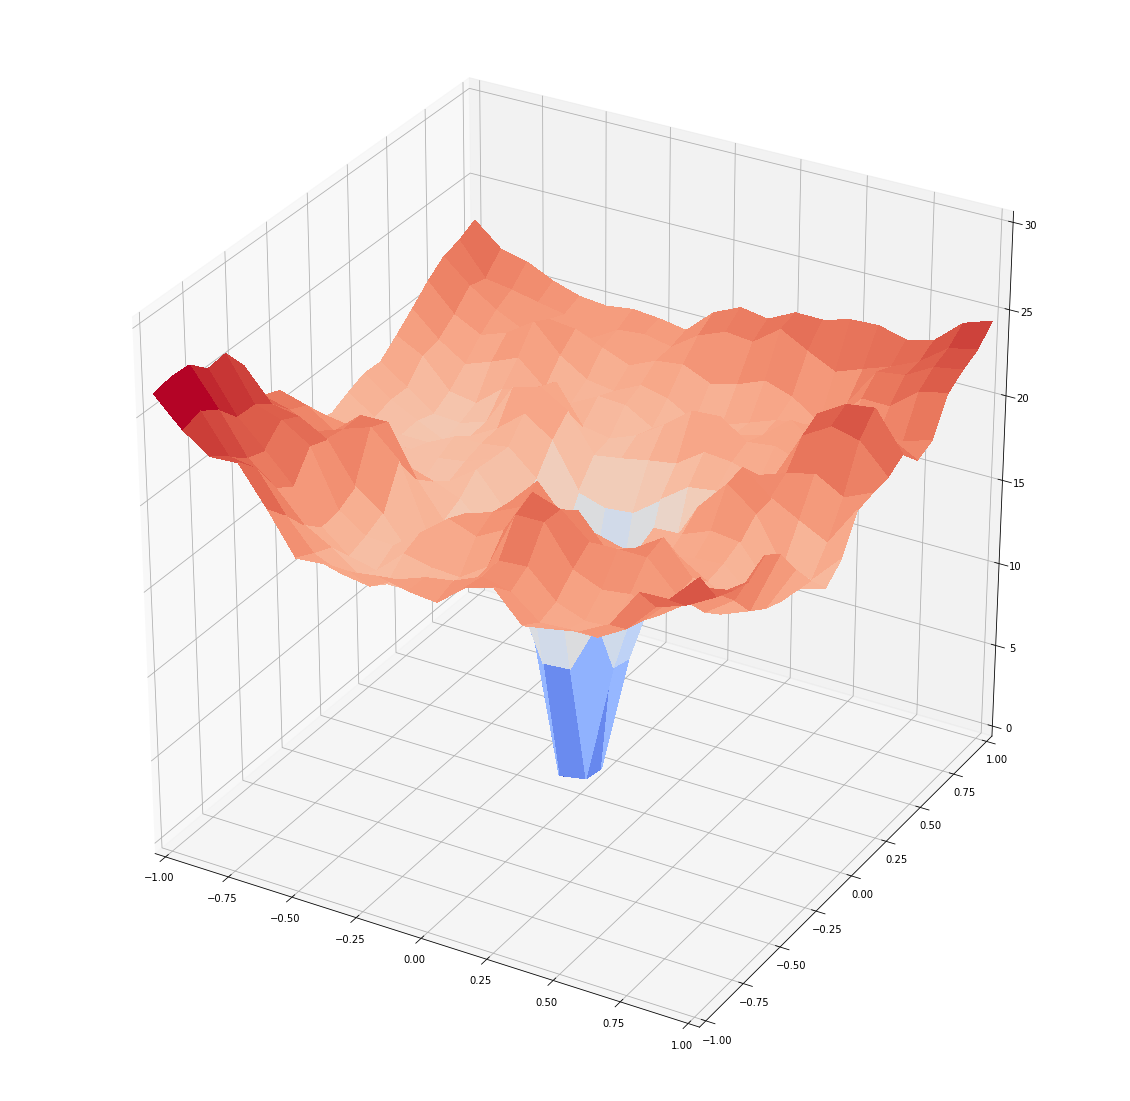

In [ ]:
generate_plots(model_ident, dataset_name, optimizer_name, "running_loss")

In [ ]:
X, Y = np.meshgrid(range(-3, 3), range(-3, 3))
X,Y

(array([[-3, -2, -1,  0,  1,  2],
        [-3, -2, -1,  0,  1,  2],
        [-3, -2, -1,  0,  1,  2],
        [-3, -2, -1,  0,  1,  2],
        [-3, -2, -1,  0,  1,  2],
        [-3, -2, -1,  0,  1,  2]]), array([[-3, -3, -3, -3, -3, -3],
        [-2, -2, -2, -2, -2, -2],
        [-1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2]]))